# Music Style Transfer

*By Gabe Kerr, Gray Marchese and Erik Swenson (Team EGG)*


---



Our goal is to implement style transfer with a neural network that has learned how to generate music.  We attempt to capture the essential elements of a corpus of music samples, then transfer these elements to a simple melody.

Deep learning has been successful in capturing the style of visual artists and transferring it to other images. It has also proven successful in transferring the writing style of an author to other bodies of text.  We hypothesize that a neural network that deals with temporal data will be able to similarly capture the style of a piece of music or composer and transfer that style to another piece of music to create a novel piece of music.

As an example of the types of inputs and outputs we're working with, the .zip file that goes with this notebook includes three different MIDI files:
1. An example sequence generated by the pre-trained Final Fantasy network (trained_example.mid).
2. An example of a simple melody used as input for the style transfer process (twinkle_twinkle.mid).
3. An example of the result of our attempt at musical style transfer (styled_song.mid).

## Initial Setup


In [1]:
# We have input melodies and pre-trained weights for style transfer that we need
# load here.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Installing packages and cloning git repos
!pip install music21
!pip install h5py
!git clone https://github.com/Skuldur/Classical-Piano-Composer.git

Cloning into 'Classical-Piano-Composer'...
remote: Enumerating objects: 150, done.
remote: Total 150 (delta 0), reused 0 (delta 0), pack-reused 150
Receiving objects: 100% (150/150), 117.92 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
# imports
import keras
from keras import backend as K
import tensorflow as tf
import music21
import h5py
import os
import numpy as np

Using TensorFlow backend.


In [0]:
os.chdir('Classical-Piano-Composer')

# Helper Functions

The functions defined below are helpful for handling musical input and generating music using a neural network.  They come from [this repo](https://github.com/Skuldur/Classical-Piano-Composer) and utilize a python general purpose music library called music21.  The repo contains a pre-trained generative neural network (LSTM-based) trained on music from the Final Fantasy games in the form of MIDI files.  We will discuss later how we use the weights in this pre-trained network.

In [0]:
from lstm import get_notes, prepare_sequences

In [0]:
""" This module generates notes for a midi file using the
  trained neural network """
import pickle
import numpy
import keras
from music21 import instrument, note, stream, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation

def generate(idx, notes):
  """ Generate a piano midi file """
  #load the notes used to train the model
  #notes = get_notes()

  # Get all pitch names
  pitchnames = sorted(set(item for item in notes))
  # Get all pitch names
  n_vocab = len(set(notes))

  network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
  model = create_network(normalized_input, n_vocab)
  prediction_output, pattern = generate_notes(model, network_input, idx, pitchnames, n_vocab)
  create_midi(prediction_output)
  
  return pattern


def prepare_sequences(notes, pitchnames, n_vocab):
  """ Prepare the sequences used by the Neural Network """
  # map between notes and integers and back
  note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

  sequence_length = 100
  network_input = []
  output = []
  for i in range(0, len(notes) - sequence_length, 1):
      sequence_in = notes[i:i + sequence_length]
      sequence_out = notes[i + sequence_length]
      network_input.append([note_to_int[char] for char in sequence_in])
      output.append(note_to_int[sequence_out])

  n_patterns = len(network_input)

  # reshape the input into a format compatible with LSTM layers
  normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
  # normalize input
  normalized_input = normalized_input / float(n_vocab)

  return (network_input, normalized_input)

def create_network(network_input, n_vocab):
  """ create the structure of the neural network """
  model = Sequential()
  model.add(LSTM(
      512,
      input_shape=(network_input.shape[1], network_input.shape[2]),
      return_sequences=True
  ))
  model.add(Dropout(0.3))
  model.add(LSTM(512, return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(512))
  model.add(Dense(256))
  model.add(Dropout(0.3))
  model.add(Dense(n_vocab+1))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

  # Load the weights to each node
  model.load_weights('new_weights.hdf5')

  return model

def generate_notes(model, network_input, idx, pitchnames, n_vocab):
  """ Generate notes from the neural network based on a sequence of notes """
  # pick a random sequence from the input as a starting point for the prediction
  #start = numpy.random.randint(0, len(network_input)-1)
  start = idx

  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

  pattern = network_input[start]
  prediction_output = []

  # generate 500 notes
  #for note_index in range(500):
  for note_index in range(100):

      prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
      prediction_input = prediction_input / float(n_vocab)

      prediction = model.predict(prediction_input, verbose=0)

      index = numpy.argmax(prediction)
      result = int_to_note[index]
      prediction_output.append(result)

      pattern.append(index)
      pattern = pattern[1:len(pattern)]

  return prediction_output, pattern

def create_midi(prediction_output):
  """ convert the output from the prediction to notes and create a midi file
      from the notes """
  offset = 0
  output_notes = []

  # create note and chord objects based on the values generated by the model
  for pattern in prediction_output:
      # pattern is a chord
      if ('.' in pattern) or pattern.isdigit():
          notes_in_chord = pattern.split('.')
          notes = []
          for current_note in notes_in_chord:
              new_note = note.Note(int(current_note))
              new_note.storedInstrument = instrument.Piano()
              notes.append(new_note)
          new_chord = chord.Chord(notes)
          new_chord.offset = offset
          output_notes.append(new_chord)
      # pattern is a note
      else:
          new_note = note.Note(pattern)
          new_note.offset = offset
          new_note.storedInstrument = instrument.Piano()
          output_notes.append(new_note)

      # increase offset each iteration so that notes do not stack
      offset += 0.5

  midi_stream = stream.Stream(output_notes)

  midi_stream.write('midi', fp='test_output.mid')
  
  
def generate_notes_from_melody(normalized_meloday_seq, network_input, idx, pitchnames, n_vocab):
  """ Generate notes from the neural network based on a sequence of notes """
  # pick a random sequence from the input as a starting point for the prediction
  #start = numpy.random.randint(0, len(network_input)-1)
  start = idx

  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

  #pattern = network_input[start]
  pattern = normalized_meloday_seq
  prediction_output = []

  # generate 500 notes
  #for note_index in range(500):
  for note_index in range(100):

      prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
      prediction_input = prediction_input / float(n_vocab)

      prediction = model.predict(prediction_input, verbose=0)

      index = numpy.argmax(prediction)
      result = int_to_note[index]
      prediction_output.append(result)

      pattern = np.concatenate((pattern, np.array([index])))
      pattern = pattern[1:len(pattern)]

  return prediction_output, pattern


def generate_from_melody(normalized_melody_seq, notes):
  """ Generate a piano midi file """
  #load the notes used to train the model
  #notes = get_notes()

  # Get all pitch names
  pitchnames = sorted(set(item for item in notes))
  # Get all pitch names
  n_vocab = len(set(notes))

  network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
  model = create_network(normalized_input, n_vocab)
  prediction_output, pattern = generate_notes_from_melody(normalized_melody_seq, network_input, 0, pitchnames, n_vocab)
  create_midi(prediction_output)
  
  return pattern

def generate_from_melody_training(model, input_sequences, output_sequences, n_vocab, normalized_melody_seq, notes):
  """ Generate a piano midi file """
  # Get all pitch names
  pitchnames = sorted(set(item for item in notes))
  _, pattern = generate_notes_from_melody(normalized_melody_seq, input_sequences, 0, pitchnames, n_vocab)
  
  return pattern

# Vocabulary
Here, we build up a vocabulary of notes and chords that will be used as input/output for the neural network.  Each unique note or chord (combination of notes) is represented by a unique integer ID and placed in a list.  The list is then normalized by it's size.  The resultant list, then, is just a large array of discrete values between zero and one.

We make two large simplifications here:
1. All notes are equal duration (this causes the output to be very rigid, but decreases the size of the feature space significantly).
2. We don't transpose all the inputs into the same key.  In the musical context, this is called translational invariance.  For example, in the key of C, the first two notes of "Twinkle, Twinkle Little Star" are C and G.  In the key of D, the first two notes are D and A.  However, they are spaced the same relative to each other and sound exactly the same.  Transposing all the input melodies into the same key would reduce the amount of learning the network would have to do, but is also a time consuming task that we just did not have time for.



In [7]:
notes = get_notes()

Parsing midi_songs/relmstheme-piano.mid
Parsing midi_songs/FF4.mid
Parsing midi_songs/ff8-lfp.mid
Parsing midi_songs/thenightmarebegins.mid
Parsing midi_songs/FFIX_Piano.mid
Parsing midi_songs/sandy.mid
Parsing midi_songs/DOS.mid
Parsing midi_songs/z_aeristhemepiano.mid
Parsing midi_songs/VincentPiano.mid
Parsing midi_songs/FF3_Battle_(Piano).mid
Parsing midi_songs/ff11_awakening_piano.mid
Parsing midi_songs/Final_Fantasy_Matouyas_Cave_Piano.mid
Parsing midi_songs/BlueStone_LastDungeon.mid
Parsing midi_songs/roseofmay-piano.mid
Parsing midi_songs/Life_Stream.mid
Parsing midi_songs/Fiend_Battle_(Piano).mid
Parsing midi_songs/FF6epitaph_piano.mid
Parsing midi_songs/Rydia_pc.mid
Parsing midi_songs/bcm.mid
Parsing midi_songs/braska.mid
Parsing midi_songs/gerudo.mid
Parsing midi_songs/Eternal_Harvest.mid
Parsing midi_songs/ff7-mainmidi.mid
Parsing midi_songs/ultros.mid
Parsing midi_songs/electric_de_chocobo.mid
Parsing midi_songs/figaro.mid
Parsing midi_songs/tifap.mid
Parsing midi_songs/fo

In [0]:
pitchnames = sorted(set(item for item in notes))
n_vocab = len(set(notes))
input_sequences, output_sequences = prepare_sequences(notes, pitchnames, n_vocab)

In [0]:
preds = np.array(generate(0, notes))

In [10]:
np.array(preds) / n_vocab

array([0.83240223, 0.31005587, 0.89106145, 0.94413408, 0.89106145,
       0.59776536, 0.99441341, 0.87150838, 0.9273743 , 0.9273743 ,
       0.94413408, 0.89106145, 0.32402235, 0.87150838, 0.83240223,
       0.99441341, 0.92458101, 0.99162011, 0.79888268, 0.83519553,
       0.94134078, 0.89385475, 0.99162011, 0.94692737, 0.79608939,
       0.31005587, 0.83240223, 0.89106145, 0.94692737, 0.05586592,
       0.9972067 , 0.89385475, 0.87430168, 0.83519553, 0.51675978,
       0.96089385, 0.79888268, 0.87430168, 0.83519553, 0.88826816,
       0.32402235, 0.79888268, 0.06424581, 0.9972067 , 0.94692737,
       0.89385475, 0.87430168, 0.83519553, 0.98882682, 0.88826816,
       0.99162011, 0.04748603, 0.22067039, 0.98882682, 0.88826816,
       0.99162011, 0.83519553, 0.87430168, 0.89385475, 0.94413408,
       0.99441341, 0.98882682, 0.88826816, 0.99162011, 0.72625698,
       0.61731844, 0.98882682, 0.88826816, 0.99162011, 0.98882682,
       0.88826816, 0.9972067 , 0.99162011, 0.94692737, 0.89385

# Loss Function

We were inspired by the loss function we used in our image style transfer homework.  We measure loss by combining two separate metrics, content loss and style loss.  Content loss is the L2 norm of  corresponding notes in the input melody and the generated output.  Style loss is the sum of L2 norms between corresponding weights of two separate networks with identical architectures.

The first network is the pre-trained generative network which will not be modified during the style transfer process.  The second network is mostly randomly initialized (biases are initialized to zeros).  During the style transfer process, we will modify the weights of the second network to try to "match" those of the first.

We hope that loss functions representing both the content and the style will allow us to preserve most of the musical content in the original melody, but with an added Final Fantasy flare.  The tradeoff between preserving content and preserving style can be managed via two scaling hyperparameters alpha (content loss multiplier) and beta (style loss multiplier).

In [0]:
def content_loss(input_sequence, output_sequence):
  cl = tf.reduce_sum(tf.square(input_sequence - output_sequence))
  return cl


def style_loss(trained_model, new_model):
  num_layers = len(trained_model.layers)
  loss = tf.constant(0.0, dtype=tf.float32)
  
  # Loop through weights
  for i in range(num_layers):
    trained_layer = trained_model.layers[i]
    new_layer = new_model.layers[i]
    # Check if layer is LSTM or Dense
    if not (str(type(trained_layer) == "<class 'keras.layers.recurrent.LSTM'>")) \
      and not (str(type(trained_layer) == "<class 'keras.layers.core.Dense'>")):
      continue
  
    trained_weights = trained_layer.weights
    new_weights = new_layer.weights 
    for j in range(len(trained_layer.weights)):
      # WTF??  Why does tf.linalg.norm(trained_weights[j] - new_weights[j]) work?
      # We think that, because some of these differences are very small, the
      # square root has a very hard time with the small input and results in NaN.
      loss += tf.reduce_sum(tf.square(trained_weights[j] - new_weights[j]))
      
  return loss


def total_loss(input_sequence, output_sequence, trained_model, new_model, alpha, beta):
  return tf.cast(alpha*content_loss(input_sequence, output_sequence), tf.float64) \
          + tf.cast(beta*style_loss(trained_model, new_model), tf.float64)

# Training Loop

In [0]:
def transfer_style(input_melody, trained_model, prog_model, hparams):
  
  # Parse the dictionary of hyperparameters.
  learning_rate = None
  alpha = None
  beta = None
  eps = None
  if not hparams['learning_rate']:
    learning_rate = 0.001
  else:
    learning_rate = hparams['learning_rate']
  if not hparams['alpha']:
    alpha = 1.0
  else:
    alpha = hparams['alpha']
  if not hparams['beta']:
    beta = 1.0
  else:
    beta = hparams['beta']
  if not hparams['eps']:
    eps = 0.1
  else:
    eps = hparams['eps']
  
  # Make sure we're not backpropagating to the pre-trained model layers.
  for layer in trained_model.layers:
    layer.trainable = False
    
  vars_to_update = []
      
  # Define the training loop.
  last_tot_loss = 999999999999.99
  output_sequence = None
  loss_history = []
  with tf.Session() as sess:
    print("Using Hyperparameters:")
    print("\tLearning Rate: {}".format(learning_rate))
    print("\tAlpha: {}".format(alpha))
    print("\tBeta: {}".format(beta))

    # Assume that the prog_model has randomly initialized all variables in LSTM
    # and Dense layers.
    var_init = tf.global_variables_initializer()
    sess.run(var_init)
    
    for i in range(len(prog_model.layers)):
      layer = prog_model.layers[i]
      layer_name = layer.name
      
      # Check if layer is LSTM or Dense
      # TODO: Do we really want to update the Dense layers here?
      if not (str(type(layer) == "<class 'keras.layers.recurrent.LSTM'>")) and \
          not (str(type(layer) == "<class 'keras.layers.core.Dense'>")):
        continue        
      
      vars_to_update += \
        [tf_var for tf_var in tf.trainable_variables() if layer_name in tf_var.name]
    
    # Pass input seq and output seq and two different models to total_loss.
    output_sequence = generate_from_melody_training(prog_model, input_sequences, output_sequences, n_vocab, input_melody, notes)
    output_sequence /= n_vocab
    cont_loss = content_loss(input_melody, output_sequence)
    sty_loss = style_loss(trained_model, prog_model)
    tot_loss = total_loss(input_melody, output_sequence, trained_model, prog_model, alpha, beta)
    
    
    
    # Update the weights in each layer of prog_model based on the total loss.
    update_op = tf.train.AdamOptimizer(learning_rate, name="ERIK_ADAM") \
      .minimize(tot_loss, var_list=vars_to_update)
    
    # Assume that the prog_model has randomly initialized all variables in LSTM
    # and Dense layers.
    var_init = tf.global_variables_initializer()
    sess.run(var_init)
    
    satisfied = False
    counter = 1

    while counter <= 5:
      print("Epoch {}:".format(counter))
      
      # Generate an output sequence from the input sequence.
      if counter != 1:
        output_sequence = generate_from_melody_training(prog_model, input_sequences, output_sequences, n_vocab, input_melody, notes)
        output_sequence /= n_vocab
      
      print("\tOutput Sequence: {}".format(output_sequence))
      cl = sess.run(content_loss(input_melody, output_sequence))
      sl = sess.run(style_loss(trained_model, prog_model))
      tl = sess.run(tot_loss)
      tot_loss = total_loss(input_melody, output_sequence, trained_model, prog_model, alpha, beta)
      sess.run(update_op)
      
      loss_history.append((cl,sl,tl))
      print("\tContent: {}\n\tStyle: {}\n\tTotal: {}".format(cl, sl, tl))
      
      counter += 1

  return output_sequence, loss_history
        

# Generate Input Melodies

Here we transform a MIDI version of the "Twinkle, Twinkle Little Star" melody into an input sequence that can be digested by our network.

In [13]:
# Parse a MIDI file and extrac the notes.
twinkle_stream = music21.converter.parse("/content/drive/My Drive/deep_learning/midis/melodies/twinkle_twinkle.mid")
only_part = twinkle_stream.parts[0]
melody_notes = []
for the_note in only_part:
  if isinstance(the_note, music21.note.Note):
    melody_notes.append(the_note)

# Convert the notes in the melody to our vocab.
melody = []
for the_note in melody_notes:
  note_str = the_note.step + str(the_note.octave)
  index = pitchnames.index(note_str)
  melody.append(index)
  
melody = np.array(melody) / n_vocab
curr_ind = 0
while len(melody) < 100:
  melody = np.concatenate((melody, [melody[curr_ind]]))
  curr_ind += 1

print("Twinkle Length: {}".format(len(melody)))
print(melody)

Twinkle Length: 100
[0.86871508 0.86871508 0.99162011 0.99162011 0.79608939 0.79608939
 0.99162011 0.95810056 0.95810056 0.92458101 0.92458101 0.88826816
 0.88826816 0.86871508 0.99162011 0.99162011 0.95810056 0.95810056
 0.92458101 0.92458101 0.88826816 0.99162011 0.99162011 0.95810056
 0.95810056 0.92458101 0.92458101 0.88826816 0.86871508 0.86871508
 0.99162011 0.99162011 0.79608939 0.79608939 0.99162011 0.95810056
 0.95810056 0.92458101 0.92458101 0.88826816 0.88826816 0.86871508
 0.86871508 0.86871508 0.99162011 0.99162011 0.79608939 0.79608939
 0.99162011 0.95810056 0.95810056 0.92458101 0.92458101 0.88826816
 0.88826816 0.86871508 0.99162011 0.99162011 0.95810056 0.95810056
 0.92458101 0.92458101 0.88826816 0.99162011 0.99162011 0.95810056
 0.95810056 0.92458101 0.92458101 0.88826816 0.86871508 0.86871508
 0.99162011 0.99162011 0.79608939 0.79608939 0.99162011 0.95810056
 0.95810056 0.92458101 0.92458101 0.88826816 0.88826816 0.86871508
 0.86871508 0.86871508 0.99162011 0.991620

# Preparation for Training

Here we load up the pre-trained LSTM model and randomly initialize a new model to be modified by the style transfer process.  We also define the relevant hyperparameters for training.

In [0]:
# Load pre-trained model
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import Sequential
from keras import backend as K

K.clear_session()
tf.reset_default_graph()

model = Sequential()
model.add(LSTM(512, input_shape=(100, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(512))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(359))
model.add(Activation('softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
# Load the weights to each node
model.load_weights('new_weights.hdf5')

# Make a copy of the trained model that we'll modify for style transfer purposes.
hparams = {}
hparams['learning_rate'] = 1e-2
hparams['alpha'] = 5e-1   # Weight of content loss
hparams['beta'] = 5e-4    # Weight of style loss
hparams['eps'] = 5.0      # Delta loss stopping criteria

transfer_model = Sequential()
transfer_model.add(LSTM(512, input_shape=(100, 1), return_sequences=True))
transfer_model.add(Dropout(0.3))
transfer_model.add(LSTM(512, return_sequences=True))
transfer_model.add(Dropout(0.3))
transfer_model.add(LSTM(512))
transfer_model.add(Dense(256))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(359))
transfer_model.add(Activation('softmax'))

# Begin Style Transfer Process

In [15]:
out_song, loss_history = transfer_style(melody, model, transfer_model, hparams)

Using Hyperparameters:
	Learning Rate: 0.05
	Alpha: 0.05
	Beta: 0.0005
Epoch 1:
	Output Sequence: [0.24301676 0.50837989 0.50837989 0.50837989 0.50837989 0.50837989
 0.50837989 0.50837989 0.50837989 0.50837989 0.50837989 0.50837989
 0.50837989 0.50837989 0.50837989 0.50837989 0.50837989 0.50837989
 0.50837989 0.50837989 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676 0.24301676
 0.24301676 0.24301676 0.243016

# Visualize the Loss

Below are some plots of the evolution of different loss metrics throughout the style transfer process.

Text(0.5,0,'iteration')

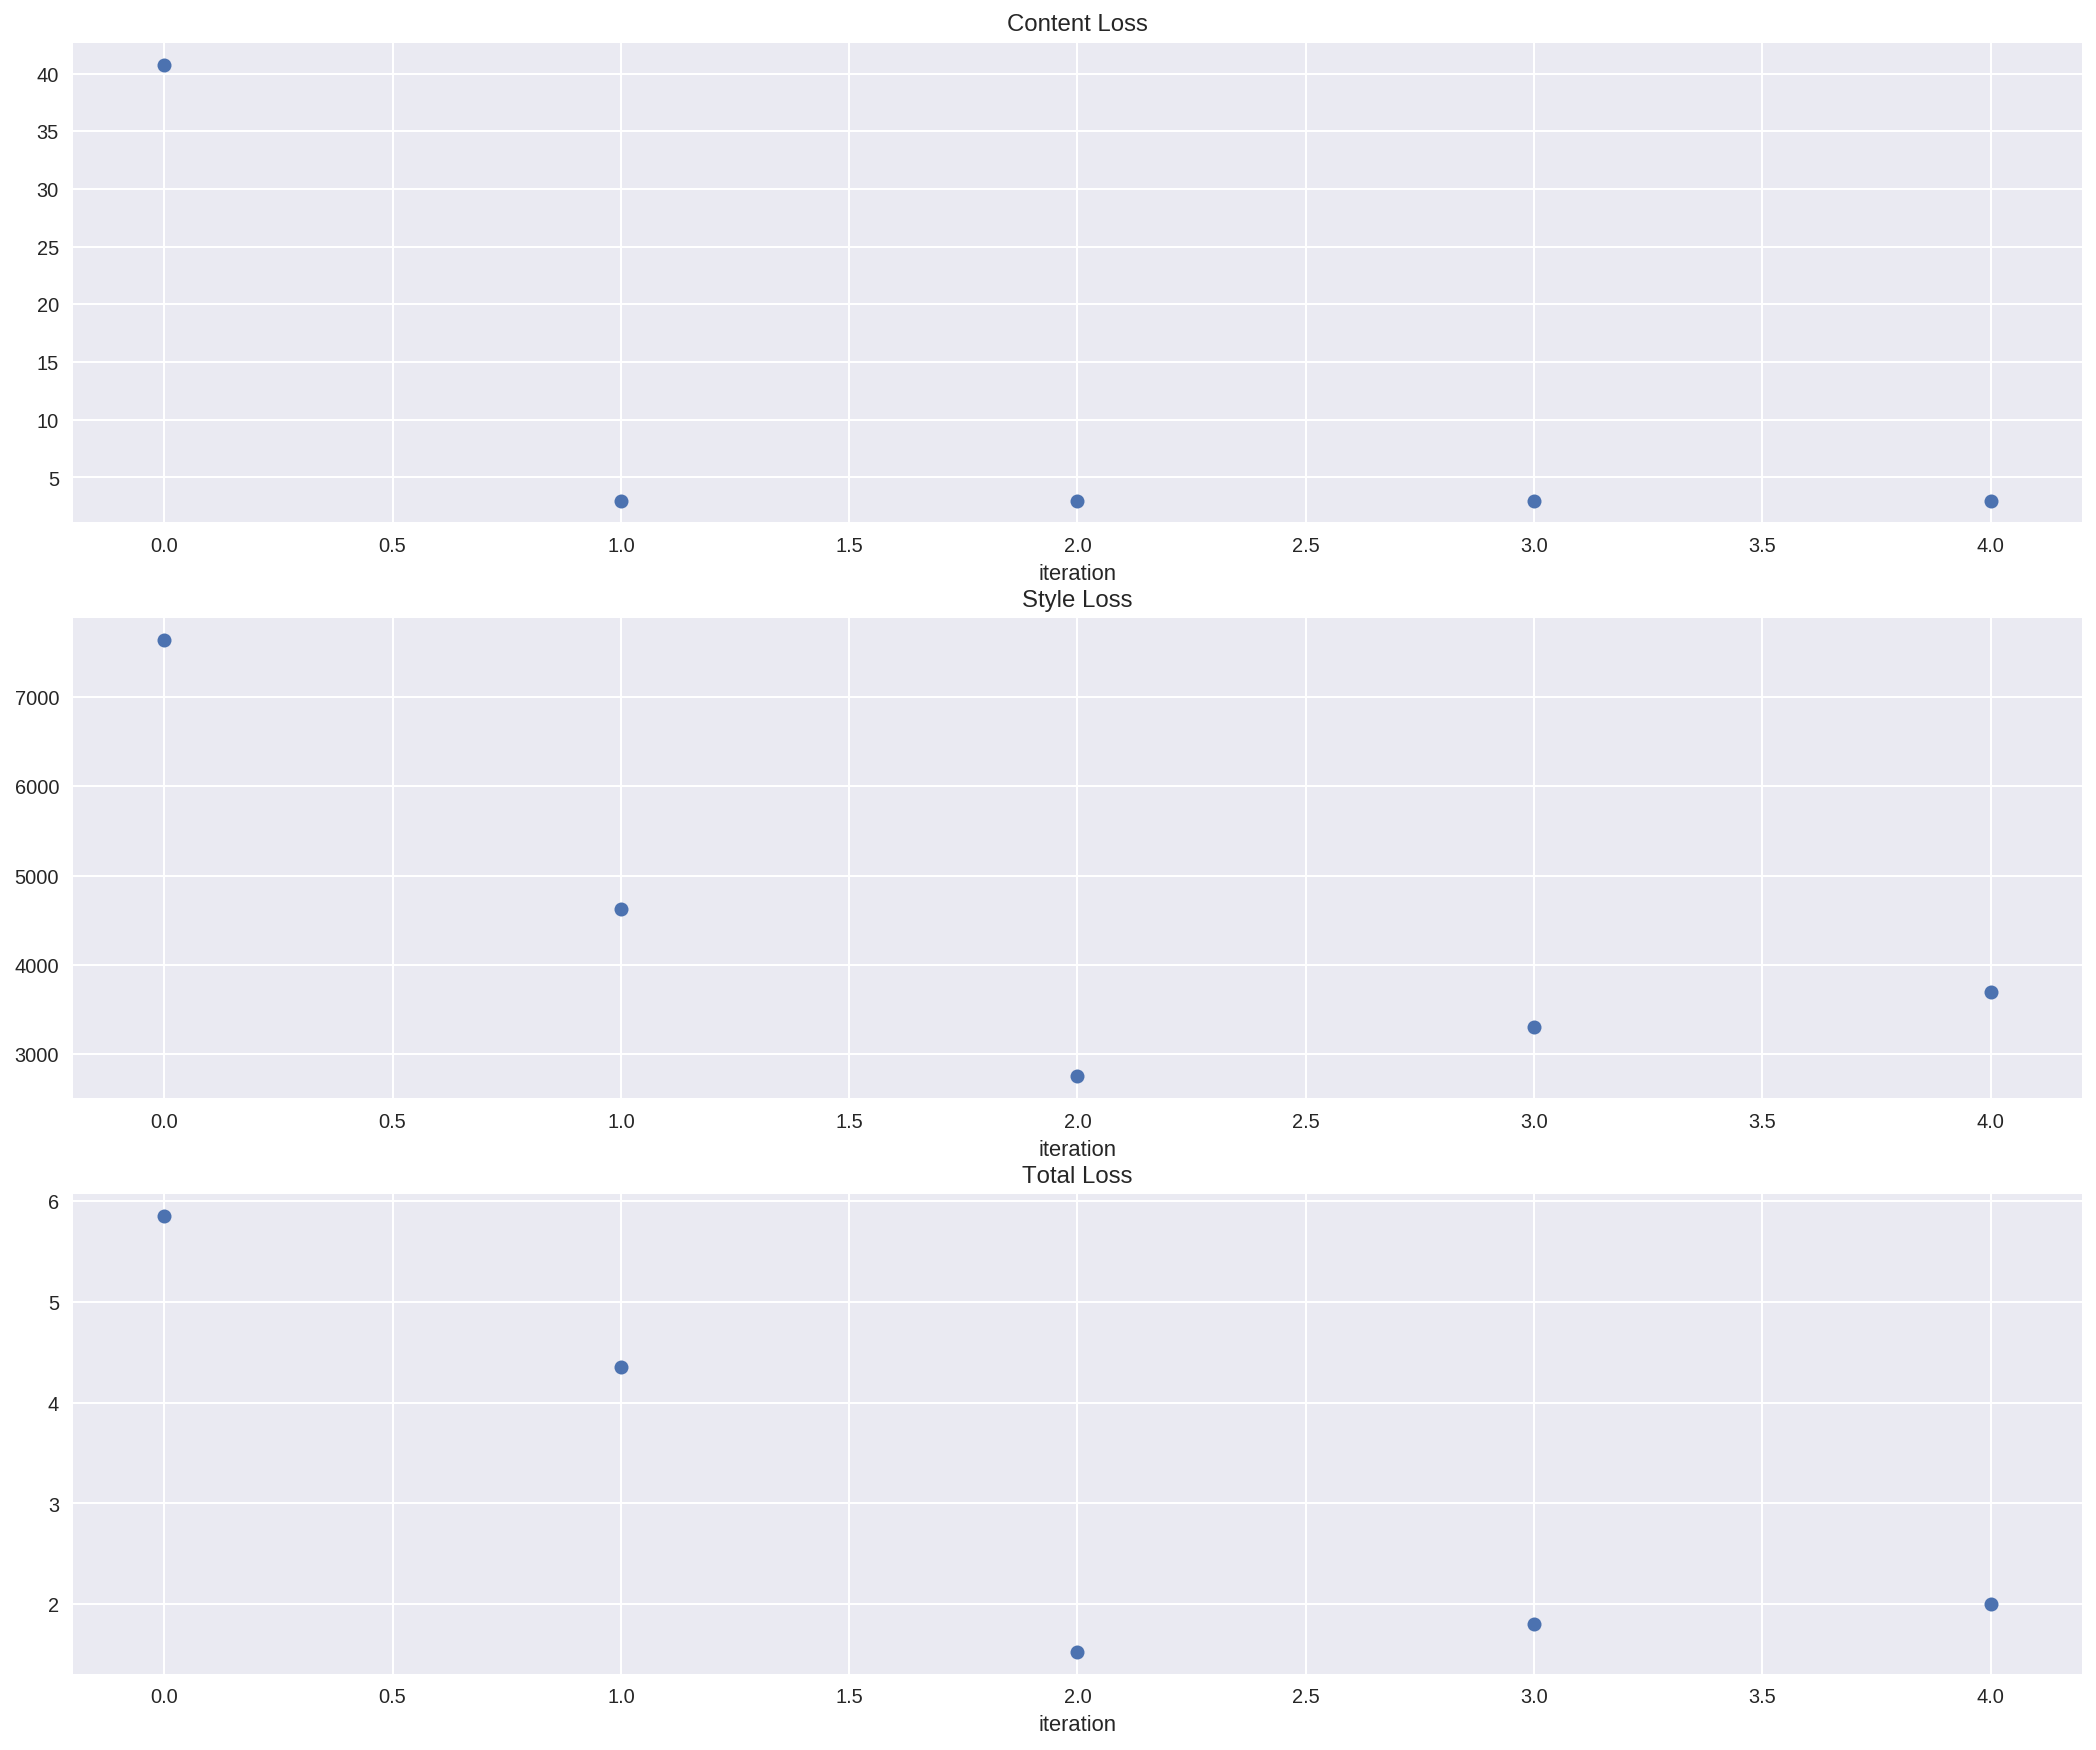

In [23]:
import matplotlib.pyplot as plt

cl, sl, tl = zip(*loss_history)

plt.figure(figsize = (18,15))
plt.subplot(3,1,1)
plt.title("Content Loss")
plt.plot(cl, 'o')
plt.xlabel('iteration')

plt.subplot(3,1,2)
plt.title("Style Loss")
plt.plot(sl, 'o')
plt.xlabel('iteration')

plt.subplot(3,1,3)
plt.title("Total Loss")
plt.plot(tl, 'o')
plt.xlabel('iteration')


# Examine the Output

We print out the sequence in terms of network vocabulary (defined above) for reference and then convert it to a MIDI file so that we can hear the results.

In the early training iterations, the weights governing state change are randomly initialized.  This seems to lead to an output sequence that is highly monotone (the same note played over and over again).  It is possible that we just haven't gotten far enough in the style transfer process to see the learning overcome this problem.  Each training epoch is very time consuming since we generate a new output sequence (via the pre-trained network) in each iteration.

In [22]:
print(out_song)

[0.9273743  0.43854749 0.43854749 0.43854749 0.43854749 0.43854749
 0.43854749 0.43854749 0.43854749 0.43854749 0.43854749 0.93854749
 0.9273743  0.9273743  0.43854749 0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.9273743  0.9273743  0.9273743  0.9273743  0.9273743  0.9273743
 0.92737

In [0]:
def create_midi_with_name(prediction_output, pitchnames, filename):
  """ convert the output from the prediction to notes and create a midi file
      from the notes """
  offset = 0
  output_notes = []
  int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
  predicted_notes = [int_to_note[x] for x in prediction_output]

  # create note and chord objects based on the values generated by the model
  for pattern in predicted_notes:
      # pattern is a chord
      if ('.' in pattern) or pattern.isdigit():
          notes_in_chord = pattern.split('.')
          notes = []
          for current_note in notes_in_chord:
              new_note = note.Note(int(current_note))
              new_note.storedInstrument = instrument.Piano()
              notes.append(new_note)
          new_chord = chord.Chord(notes)
          new_chord.offset = offset
          output_notes.append(new_chord)
      # pattern is a note
      else:
          new_note = note.Note(pattern)
          new_note.offset = offset
          new_note.storedInstrument = instrument.Piano()
          output_notes.append(new_note)

      # increase offset each iteration so that notes do not stack
      offset += 0.5

  midi_stream = stream.Stream(output_notes)

  midi_stream.write('midi', fp=filename)

In [19]:
denormalized_out_song = out_song * n_vocab

denormalized_out_song

array([332., 157., 157., 157., 157., 157., 157., 157., 157., 157., 157.,
       336., 332., 332., 157., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332., 332., 332., 332., 332., 332., 332., 332., 332., 332., 332.,
       332.])

In [0]:
create_midi_with_name(denormalized_out_song, pitchnames, '/content/drive/My Drive/deep_learning/midis/styled_song.mid')
create_midi_with_name(preds, pitchnames, '/content/drive/My Drive/deep_learning/midis/trained_example.mid')

# Future Improvements

**Hyperparameter Optimization:**  Because it took so long to run our training loop, we did not spend a lot of time tinkering with hyperparameters.  It is quite possible that we are very far away from the "sweet spot" and fine-tuning the tradeoff between content and style loss or optimizing the learning rate would drastically affect the output.

**Improved Content Loss:**  We realize now that our content loss function should have been more sophisticated. Currently, the notes are assigned an id according to the order that they are read into our deep learning program. This means that the distance between two notes is entirely dependent on the order in which they were read into the network rather than being dependent on how similar attributes of the notes are. In the future, we would measure the distance between notes based on the attributes of their sound and how dissonant they are with each other.

**Image Style Transfer Paradigm:**  In our brief experience with image style transfer, the "input" image starts out as noise and the actual pixels in that image are updated via gradient descent.  It would be interesting to initialize a random musical sequence (literal noise) and update the notes in that sequence via a similar process instead of the content loss indirectly affecting the output of a generative network.